In [2]:
# distributed model
# 2 areas, 20 bikes in total, equally distributed at the beginning

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

In [29]:
# initialize parameters
rate = {'lambda0' : 10.0,
        'lambda1' : 10.0,
        'lambda2' : 8.0,
        'lambda3' : 12.0,
        'omega' : 1.0,
        #'gamma' : 4.0,
        'phi' : 1.0,
        #'delta' : 1.0,
       }
broken = 0.15
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [[0.1, 0.2, 0.3, 0.4],
       [0.2, 0.1, 0.3, 0.4],
       [0.3, 0.2, 0.1, 0.4],
       [0.4, 0.2, 0.3, 0.1],]

In [90]:
# simulate situation with distributed repairing
# in this version, bikes found broken after a customer RIDING
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.W = [0]*4
        self.F = [0]*4
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        return self.state + [self.T]

    def simulate(self):
        with open('/Users/valarian/SJTU/SJTU/毕业论文/Data/simulationResult/distributed/data/distributed_nobroken_nocarriercode.csv', 'w') as fout:
            writer = csv.writer(fout)
            writer.writerow(self.R)
            writer.writerow(self.R.values())
            writer.writerow(self.reset())
            while self.T <= self.time_limit:
                writer.writerow(self.step())
        return self.served_customers / (self.T-10000)
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return 4
        elif target == 'f': return 5
        elif target == 'd': return 6
        else:
            s, t = int(target[0]), int(target[1])
            return 12 + 4*s + t
        
    def add_event(self, kind, t):
        if kind == 2: 
            next_time = random.expovariate(self.R['omega']) + max(self.T, self.W[t])
            self.W[t], start, end = next_time, t, t
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi']) + max(self.T, self.F[t])
            self.F[t], start, end = next_time, t, t

        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<0: #1-broken:
                self.state[int(start[1])+4] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[4+terminal] -= 1
            self.state[8+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            self.state[8+terminal] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>10000: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 0
run_time = 20000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
%time env.simulate()

CPU times: user 36.1 s, sys: 482 ms, total: 36.6 s
Wall time: 38.6 s


32.057775236649256

In [89]:
env.served_customers

0

In [ ]:
# calculation of pij according to the simulaiton result
names = ['a'+str(i) for i in range(env.A)]+['w'+str(i) for i in range(env.A)]+['f'+str(i) for i in range(env.A)]
names += ['r'+str(i)+str(j) for i in range(env.A) for j in range(env.A)]+['t']
df = pd.read_csv('simul_4_100_onsite_0.2broken200000.csv', names=names, 
                 index_col=None, skiprows=2)
df['t'][0] = 0.0
df['seg'] = df.t.diff()
df['seg_shift'] = df.seg.shift(-1)

In [35]:
df=df[(df.t>10000)&(df.t<30000)][:-1]
df.head()

,a0,a1,a2,a3,w0,w1,w2,w3,f0,f1,...,r21,r22,r23,r30,r31,r32,r33,t,seg,seg_shift
629190,1,0,0,0,0,0,0,0,3,0,...,0,1,1,1,0,0,1,10000.011740,0.043402,0.005377
629191,1,0,0,0,0,0,0,0,3,0,...,0,1,1,1,0,0,1,10000.017117,0.005377,0.040661
629192,1,0,0,0,0,0,0,0,3,0,...,0,1,1,1,0,0,1,10000.057778,0.040661,0.059572
629193,1,0,0,0,0,0,0,0,3,0,...,0,1,1,1,0,0,1,10000.117350,0.059572,0.034106
629194,0,0,0,0,0,0,0,0,3,0,...,0,1,1,1,0,0,1,10000.151456,0.034106,0.000464


In [36]:
# 1处为0的所有记录
#for i in ['a','b','c','d','e','f','g','h','i']:
temp0=df[df.a0==0]
temp0.head()
sum(temp0.seg_shift)/(temp0.t.max()-10000)

0.5772893003297472

100%|██████████| 50/50 [29:52<00:00, 51.76s/it] 


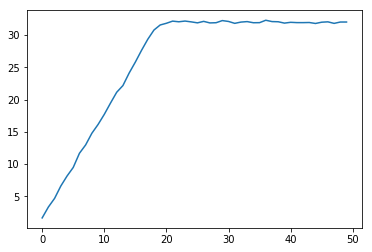

In [49]:
#the influence of phi

class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.W = [0]*4
        self.F = [0]*4
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))
        self.served_customers = 0

#         self.reset()

    def reset(self):
        self.T = 0
        self.served_customers = 0
        self.W = [0]*4
        self.F = [0]*4
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state + [self.T]

    def simulate(self):
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers/(self.T-10000)
        
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A*3 + self.A*s + t
        
    def add_event(self, kind, t):
        if kind == 2: 
            next_time = random.expovariate(self.R['omega']) + max(self.T, self.W[t])
            self.W[t], start, end = next_time, t, t
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi']) + max(self.T, self.F[t])
            self.F[t], start, end = next_time, t, t

        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         1: a bike arrives
         2: a carrier arrives
         3: a bike was fixed
        '''
        if kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()>1-broken:
                self.state[int(start[1])+self.A] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, terminal)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[self.A+terminal] -= 1
            self.state[self.A*2+terminal] += 1
            heapq.heappop(self.scheduler)
            self.add_event(3, terminal)
        elif kind == 3:
            self.state[self.A*2+terminal] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>10000: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 0
run_time = 20000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
#%time env.simulate()
result = []
for i in tqdm(range(1,51)):
    env.R['phi'] = i*0.1
    env.R['omega'] += env.R['phi']
    result.append(env.simulate())

plt.plot(result)
plt.show()

In [51]:
with open('phi_onsite_queues_1.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(rate)
    writer.writerow(rate.values())
    writer.writerow(pij)
    writer.writerow([broken])
    writer.writerow([N,A])
    writer.writerow([0.1*i for i in range(1,51)])
    writer.writerow(result)

In [91]:
# initialize parameters
rate = {'lambda0' : 10.0,
        'lambda1' : 10.0,
        'lambda2' : 8.0,
        'lambda3' : 12.0,
        #'omega' : 1.0,
        'broken' : 0.15,
        'phi' : 1.0,
        'car_move' : 1.0,
        #'delta' : 1.0,
       }
#broken = 0.2
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [[0.1, 0.2, 0.3, 0.4],
       [0.2, 0.1, 0.3, 0.4],
       [0.3, 0.2, 0.1, 0.4],
       [0.4, 0.2, 0.3, 0.1],]


100%|██████████| 2/2 [00:50<00:00, 24.97s/it]

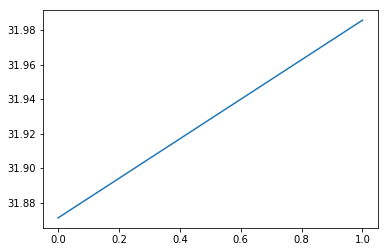

In [93]:
#the influence of phi
#the collection is no longer a queue
#but a car moving among areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.capacity = 10
        #self.W = [0]*4
        self.F = 0
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))
        self.served_customers = 0

#         self.reset()

    def reset(self):
        self.T = 0
        self.served_customers = 0
        #self.W = [0]*4
        #self.F = [0]*4
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, dummy parameter]
        heapq.heappush(self.scheduler, [0, 0, 0, 0])
        #return self.state + [self.T]

    def simulate(self):
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers/(self.T-10000)
        
                
    def get_rho(self, path):
        s, t = int(path[0]), int(path[1])
        if s==t: return 0.5
        elif abs(s-t) == 2: return 2.0
        else: return 1.0
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A*3 + self.A*s + t
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0:
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
                heapq.heappop(self.scheduler)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[int(start[1])+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[self.A*2+terminal] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
            else:
                event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, 0]
                heapq.heappush(self.scheduler, event) 
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>10000: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.get_rho(target)) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 0
run_time = 20000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
#%time env.simulate()
result = []
for i in tqdm(range(201, 203)):
    env.R['phi'] = i*0.1
    result.append(env.simulate())

plt.plot(result)
plt.show()